In [474]:
import pandas as pd
import numpy as np

import missingno as msno
from summarytools import dfSummary
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from category_encoders import CatBoostEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from warnings import filterwarnings
filterwarnings('ignore')

In [453]:
rent = pd.read_csv("olx_20230820.csv", encoding='latin')

# Exploratory Data Analysis

In [454]:
rent.head()

,aluguel,CEP,Município,Bairro,Logradouro,Condomínio,IPTU,Tamanho,Vagas na garagem,Área útil,Banheiros,Tipo,Aluguel + Condomínio,Detalhes do imóvel,Detalhes do condomínio,Área construída,Acomoda,Características
0,1.500,22020001,Rio de Janeiro,Copacabana,Avenida Nossa Senhora de Copacabana - de 46 a ...,R$ 840,R$ 123,45m²,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.300,20091005,Rio de Janeiro,Centro,Rua da Quitanda - de 79/80 ao fim,R$ 1.950,R$ 790,150m²,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,450,20260132,Rio de Janeiro,Estácio,Rua Haddock Lobo - até 120 - lado par,R$ 756,R$ 103,33m²,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000,21050700,Rio de Janeiro,Higienópolis,Rua Astreia,R$ 320,R$ 0,NaN,NaN,60m²,1,Padrão,R$ 1.320,NaN,NaN,NaN,NaN,NaN
4,3.200,22620311,Rio de Janeiro,Barra da Tijuca,Avenida Prefeito Dulcídio Cardoso - de 304 a 1...,R$ 1.250,R$ 250,NaN,1,65m²,2,Padrão,R$ 4.450,"Academia, Ar condicionado, Área de serviço, Ar...","Academia, Condomínio fechado, Elevador, Permit...",NaN,NaN,NaN


In [455]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   aluguel                 4990 non-null   object 
 1   CEP                     5000 non-null   int64  
 2   Município               5000 non-null   object 
 3   Bairro                  4950 non-null   object 
 4   Logradouro              4839 non-null   object 
 5   Condomínio              4791 non-null   object 
 6   IPTU                    4776 non-null   object 
 7   Tamanho                 2215 non-null   object 
 8   Vagas na garagem        4032 non-null   object 
 9   Área útil               1776 non-null   object 
 10  Banheiros               2740 non-null   object 
 11  Tipo                    2775 non-null   object 
 12  Aluguel + Condomínio    2088 non-null   object 
 13  Detalhes do imóvel      1798 non-null   object 
 14  Detalhes do condomínio  1622 non-null   

<Axes: >

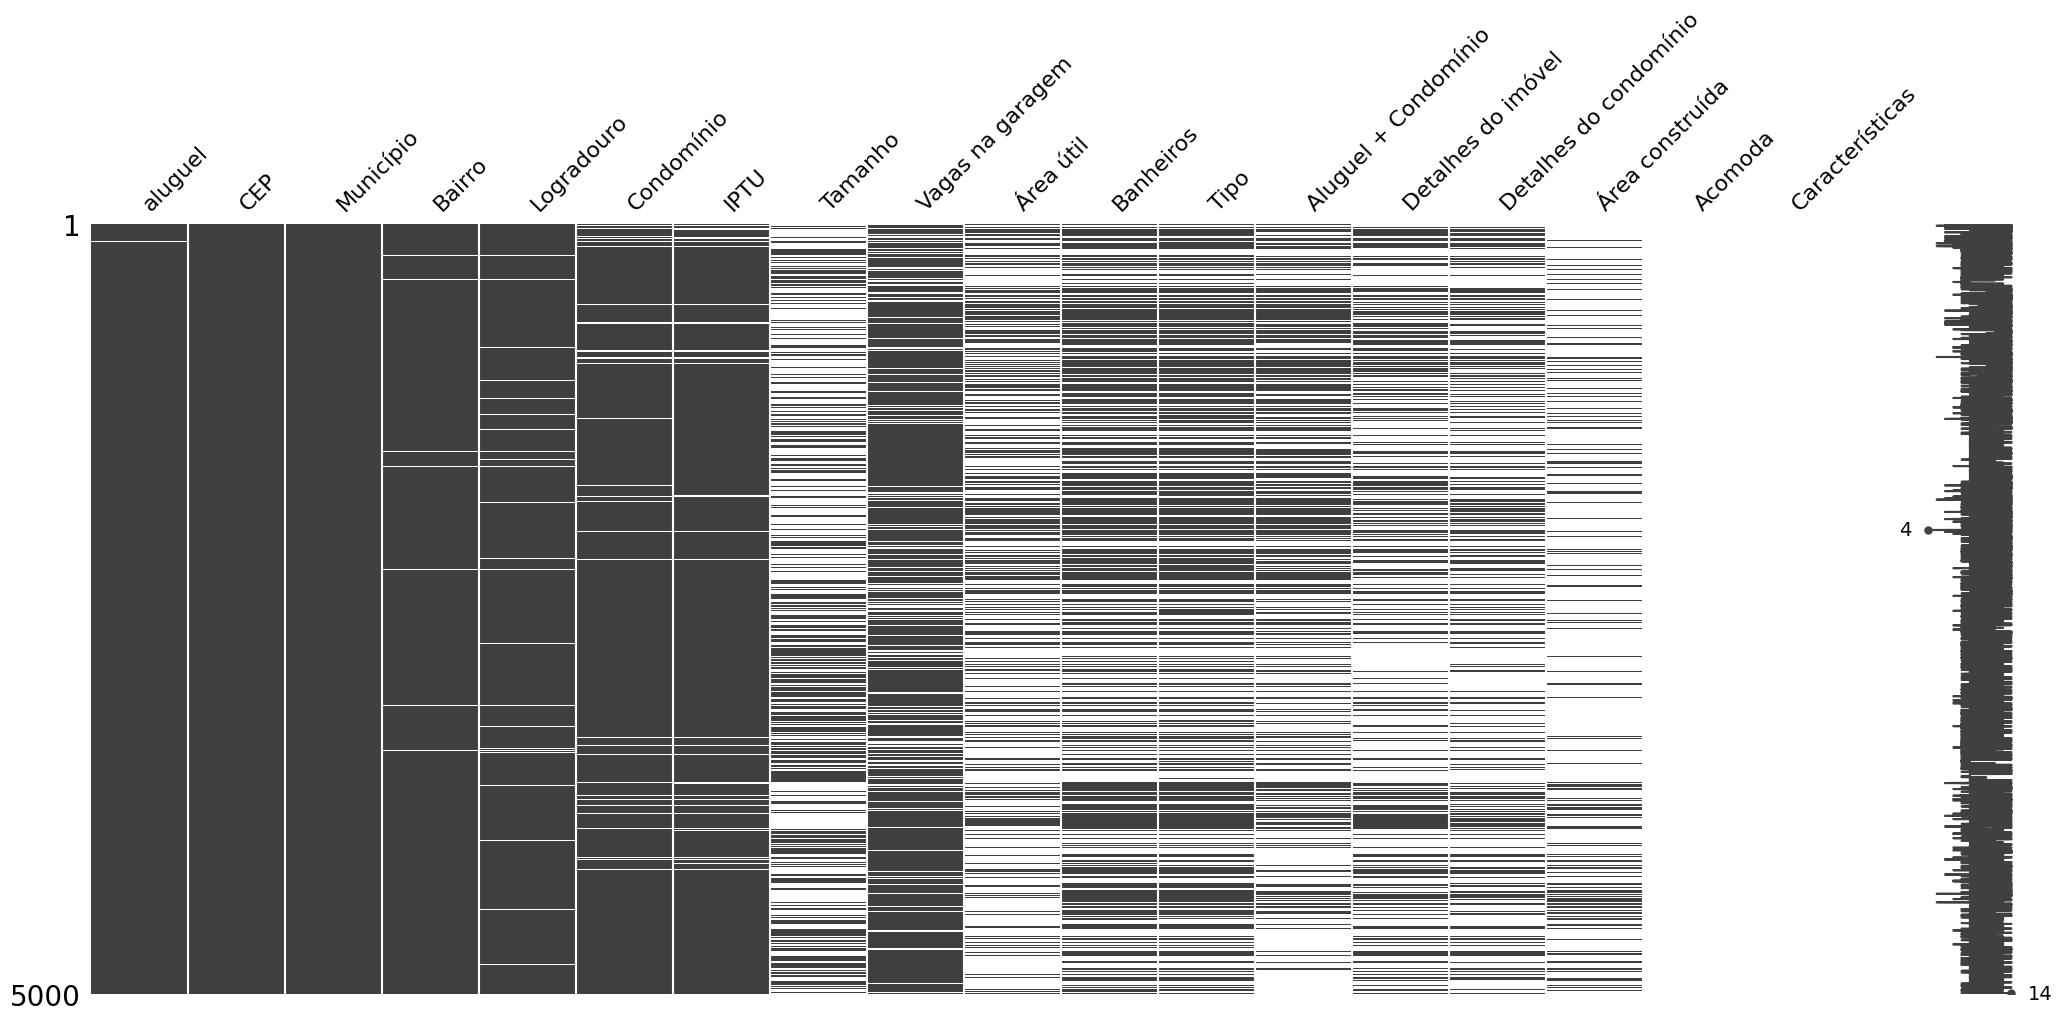

In [456]:
msno.matrix(rent)

In [457]:
pd.DataFrame({
    'Missings (N)': rent.isnull().sum(),
    'Missings RJ (N)': rent[rent['Município'] == "Rio de Janeiro"].isnull().sum(),
    'Missings (%)': rent.isnull().mean() * 100,
    'Missings RJ (%)': rent[rent['Município'] == "Rio de Janeiro"].isnull().mean() * 100
})

,Missings (N),Missings RJ (N),Missings (%),Missings RJ (%)
aluguel,10,4,0.20,0.107614
CEP,0,0,0.00,0.000000
Município,0,0,0.00,0.000000
Bairro,50,0,1.00,0.000000
Logradouro,161,81,3.22,2.179177
Condomínio,209,100,4.18,2.690342
IPTU,224,120,4.48,3.228410
Tamanho,2785,2017,55.70,54.264192
Vagas na garagem,968,782,19.36,21.038472
Área útil,3224,2311,64.48,62.173796


In [458]:
# fixing variable names
rent.columns = (rent.columns
                .str.lower()
                .str.replace(" ", "_", regex=False)
                .str.normalize('NFKD')
                .str.encode('ascii', errors='ignore')
                .str.decode('utf-8'))

In [459]:

# rent as numerical variable
rent['aluguel'] = rent['aluguel'].str.replace(r'\.', '', regex=True).astype(float)

# fixing other numerical variables
for col in ['condominio', 'iptu', 'aluguel_+_condominio']:
    rent[col] = (rent[col]
                 .str.replace("R$ ", "", regex=False)
                 .replace(r'\.', '', regex=True).astype(float))
    
for col in ['tamanho', 'area_util', 'area_construida']:
    rent[col] = (rent[col]
                .astype(str)
                .str.replace("m²", "", regex=True)
                .str.strip()
                .replace({"": None})
                .astype(float))

rent['logradouro'] = rent['logradouro'].str.split(' - ', n=1, expand=True)[0].str.strip()
    
rent['tamanho_total'] = rent[['tamanho', 'area_util', 'area_construida']].sum(axis=1, min_count=1)

for col in ['vagas_na_garagem', 'banheiros']:
    rent[col] = (rent[col]
                .astype(str)
                .str.replace(" ou mais", "", regex=True)
                .str.strip()
                .replace({"": None})
                .astype(float))
    
for col in ['cep', 'municipio', 'bairro', 'logradouro']:
    rent[col] = rent[col].astype('category')

rent = rent.drop(columns=['caracteristicas', 'acomoda', 'detalhes_do_condominio', 'detalhes_do_imovel', 'tipo', 'aluguel_+_condominio', 'tamanho', 'area_util', 'area_construida'])

rent = rent[rent['municipio'] == 'Rio de Janeiro']

In [460]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3717 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   aluguel           3713 non-null   float64 
 1   cep               3717 non-null   category
 2   municipio         3717 non-null   category
 3   bairro            3717 non-null   category
 4   logradouro        3636 non-null   category
 5   condominio        3617 non-null   float64 
 6   iptu              3597 non-null   float64 
 7   vagas_na_garagem  2935 non-null   float64 
 8   banheiros         1992 non-null   float64 
 9   tamanho_total     3651 non-null   float64 
dtypes: category(4), float64(6)
memory usage: 413.2 KB


In [461]:
rent.describe()

,aluguel,condominio,iptu,vagas_na_garagem,banheiros,tamanho_total
count,3.713000e+03,3.617000e+03,3.597000e+03,2935.000000,1992.000000,3651.000000
mean,3.097895e+05,1.207348e+04,7.905146e+03,1.220102,2.260040,387.624760
std,2.226610e+06,4.352788e+05,3.742159e+05,1.326903,1.409108,3715.479977
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,1.200000e+03,0.000000e+00,0.000000e+00,0.000000,1.000000,47.500000
50%,4.000000e+03,5.500000e+02,2.300000e+02,1.000000,2.000000,80.000000
75%,2.200000e+04,1.300000e+03,9.500000e+02,2.000000,3.000000,215.000000
max,1.000000e+08,1.850000e+07,2.242103e+07,5.000000,5.000000,200000.000000


In [462]:
rent.duplicated().sum()
rent = rent.drop_duplicates(keep='first')


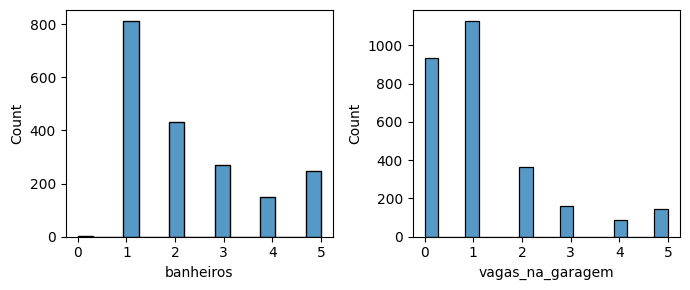

In [463]:
fig, axes = plt.subplots(1,2 ,figsize=(7,3))

sns.histplot(data=rent, x='banheiros', ax=axes[0])
sns.histplot(data=rent, x='vagas_na_garagem', ax=axes[1])

plt.tight_layout()

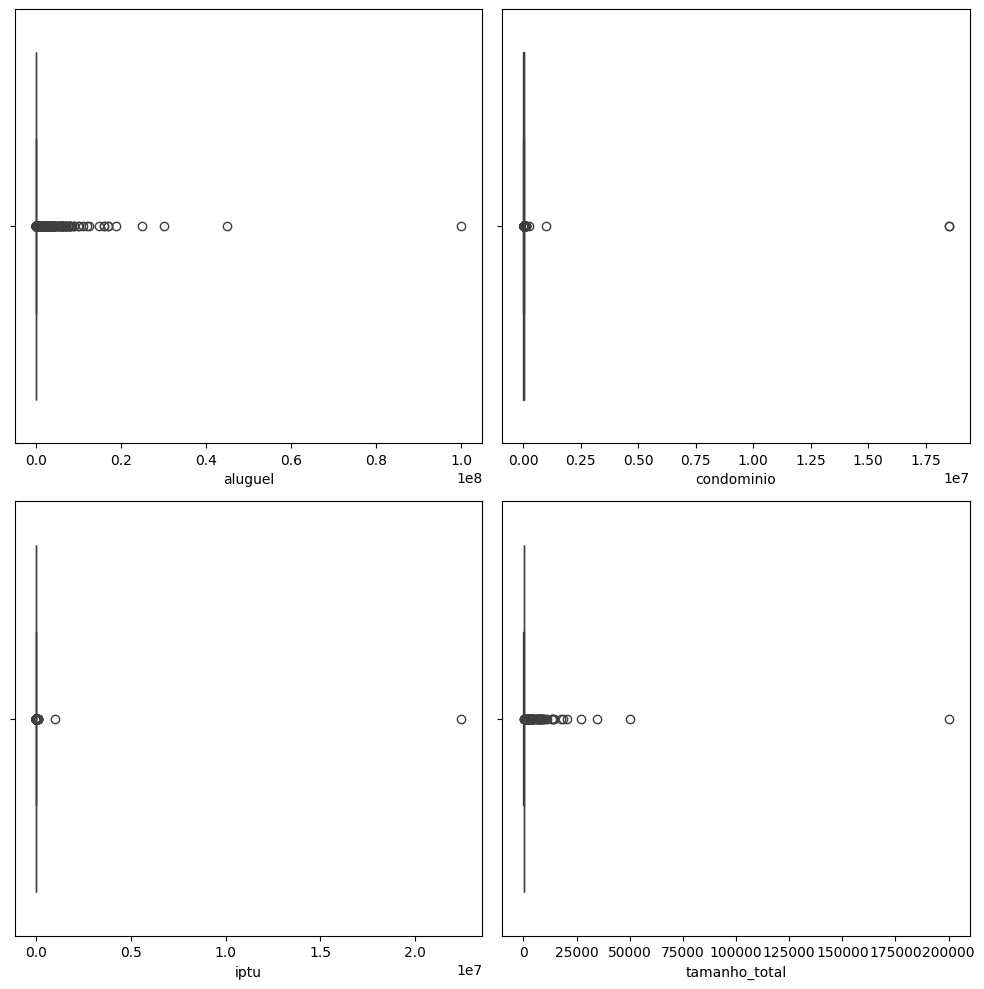

In [464]:
# theres a lot of outliers in the numerical variables
fig, axes = plt.subplots(2,2, figsize=(10,10))

sns.boxplot(data=rent, x='aluguel', ax=axes[0,0])
sns.boxplot(data=rent, x='condominio', ax=axes[0,1])
sns.boxplot(data=rent, x='iptu', ax=axes[1,0])
sns.boxplot(data=rent, x='tamanho_total', ax=axes[1,1])

plt.tight_layout()

In [465]:
rent = rent.query('aluguel < 0.8e8')
rent = rent.query('condominio < 1.5e7')
rent = rent.query('iptu < 2e7')
rent = rent.query('tamanho_total < 150000')

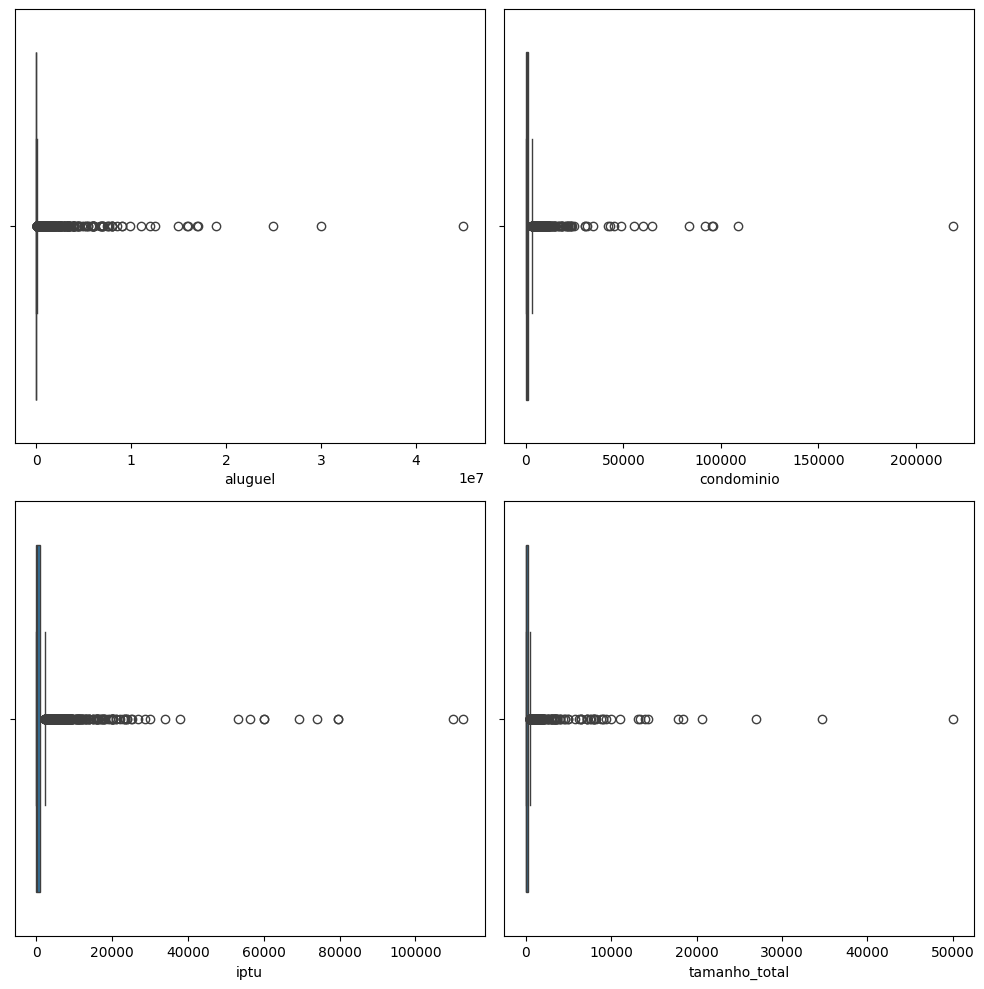

In [466]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

sns.boxplot(data=rent, x='aluguel', ax=axes[0,0])
sns.boxplot(data=rent, x='condominio', ax=axes[0,1])
sns.boxplot(data=rent, x='iptu', ax=axes[1,0])
sns.boxplot(data=rent, x='tamanho_total', ax=axes[1,1])

plt.tight_layout()

In [467]:
rent = rent.dropna()

# Modeling

In [468]:
X = rent.drop(columns=['aluguel', 'cep', 'municipio', 'logradouro'], axis=1)
y = rent['aluguel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)

Initializing the four models that I want to evaluate: 

In [436]:
model_XGBoost = XGBRegressor(n_estimators=1000, max_depth=8, learning_rate=1e-3, n_jobs=-1, random_state=123)
model_LightLGBM = LGBMRegressor(n_estimators=1000, max_depth=8, num_leaves=2^8, learning_rate=1e-3, n_jobs=-1, random_state=123, verbose=-1)
model_catboost = CatBoostRegressor(n_estimators=1000, max_depth=8, learning_rate=1e-3, random_state=123, verbose=0)
model_decision_tree = DecisionTreeRegressor(random_state=123, max_depth=8, min_samples_split=2)

In [469]:
X_train.select_dtypes(include=['category']).columns

Index(['bairro'], dtype='object')

In [470]:
# feature importance
encoder = CatBoostEncoder()

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# categorical columns transformed into numerical values
for col in X_train_encoded.select_dtypes(include=['category']).columns:
    X_train_encoded[col] = encoder.fit_transform(X_train_encoded[col], y_train)
    X_test_encoded[col] = encoder.transform(X_test_encoded[col])
    
model_XGBoost.fit(X_train_encoded, y_train)

r = permutation_importance(model_XGBoost, X_test_encoded, y_test, n_repeats=30, random_state=123)

In [471]:
importances = pd.DataFrame({'Feature': X_test_encoded.columns,
                            'Importance': r.importances_mean})

importances.sort_values(by='Importance', ascending=False)

,Feature,Importance
5,tamanho_total,0.046336
1,condominio,0.037904
3,vagas_na_garagem,0.017667
2,iptu,0.006665
4,banheiros,0.002151
0,bairro,-0.037303


## Cross-validation

In [478]:
k=5

folds = KFold(n_splits=k, shuffle=True, random_state=123)

# empty lists to store the three metrics results (MAE, MSE and R2)
absolute_errors = list()
squared_errors = list()
r2 = list()
# median_absolute_errors = list()

for k, (train_index, test_index) in enumerate(folds.split(X,y)):

    print("#------------------" + f"Fold {k+1}")

    X_train_temp, y_train_temp = X.iloc[train_index, :], y.iloc[train_index]
    X_test_temp, y_test_temp = X.iloc[test_index, :], y.iloc[test_index]

    # building the pipeline to treat categorical variables
    encoder = CatBoostEncoder()

    cat_imputer = SimpleImputer(strategy='most_frequent') # imputer for categorical variables
    num_imputer = SimpleImputer(strategy='median')        # imputer for numerical variables

    cat_pipeline = Pipeline([('encoder', encoder), ('inputer', cat_imputer)])
    num_pipeline = Pipeline([('imputer', num_imputer)])

    cat_cols = X_train_temp.select_dtypes(include=['category']).columns
    num_cols = X_train_temp.select_dtypes(exclude=['category']).columns

    # applying the pipeline on the columns of the train dataset
    X_train_temp[cat_cols] = cat_pipeline.fit_transform(X_train_temp[cat_cols], y_train_temp)
    X_train_temp[num_cols] = num_pipeline.fit_transform(X_train_temp[num_cols])

    # applying the pipeline on the columns of the test dataset
    X_test_temp[cat_cols] = cat_pipeline.transform(X_test_temp[cat_cols])
    X_test_temp[num_cols] = num_pipeline.transform(X_test_temp[num_cols])

    model_XGBoost.fit(X_train_temp, y_train_temp)

    y_pred = model_XGBoost.predict(X_test_temp)

    # metrics
    r2score = r2_score(y_test_temp, y_pred)
    mse = mean_squared_error(y_test_temp, y_pred)
    mae = mean_absolute_error(y_test_temp, y_pred)
    medae = median_absolute_error(y_test, y_pred)

    r2.append(r2score)
    squared_errors.append(mse)
    absolute_errors.append(mae)
    # median_absolute_errors.append(medae)

    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"R2: {r2score:.3f}")
    # print(f"Median Absolute Error: {medae:.3f}")


#------------------Fold 1
MAE: 603123.699
MSE: 3167990130131.560
R2: -0.061
#------------------Fold 2
MAE: 519492.031
MSE: 1359591891988.061
R2: -0.486
#------------------Fold 3


ValueError: Found input variables with inconsistent numbers of samples: [310, 309]